In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import normalize, to_categorical
from keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from keras import backend as K
from keras import optimizers
import random
%matplotlib notebook

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
def characterCrop(img, charBB):
    for i in range(4):
        if charBB[0, i] < 0:
            charBB[0, i] = 0
        if charBB[1, i] < 0:
            charBB[1, i] = 0
        if charBB[0, i] > img.shape[1]:
            charBB[0, i] = img.shape[1]
        if charBB[1, i] > img.shape[0]:
            charBB[1, i] = img.shape[0]
            
    pts = np.array(list((zip(charBB[0], charBB[1]))),dtype='int')
    
    
    #pts = np.array([[9,502],[24,501],[24,520],[9,521]])
    ## (1) Crop the bounding rect
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w].copy()
    
    ## (2) make mask
    pts = pts - pts.min(axis=0)
    
    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
    
    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask)
    
    ## (4) add the white background
    bg = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg+ dst
    dst2= np.where(dst2==(255,255,255), np.mean(croped, axis=(0,1), dtype=int).astype(np.uint8),dst2)
    
    return dst2

In [5]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

In [6]:
def random_image_augmentation(images, thetaRange=90, shearList=[0, 0, 0, 0, 0, 0, 0, 0, 0, 180], noiseType='s&p'):
    # Data augmentation
    for i, img in enumerate(images):
        im = tf.keras.preprocessing.image.random_brightness(img, (0.7,1.3)).astype(np.uint8)
        im = tf.keras.preprocessing.image.random_zoom(im, (1, 1)).astype(np.uint8)
        theta = np.random.randint(-thetaRange, thetaRange)
        #theta = 0
        shear = random.sample(shearList, 1)[0]
        #shear = 0
        im = tf.keras.preprocessing.image.apply_affine_transform(im, theta=theta, shear=shear)
        im = noisy(noiseType,im)
        images[i] = im
    return images
        

In [7]:
from PIL import Image, ImageDraw, ImageFont

def fontImgGen(shape=(32,32), colorB=(255,255,255), colorT=(0,0,0), fontS=32, xy=(0,0), prefix='labels', numberOfImages=10):
    letters = ['!','"','#','$','%',"'",'(',')','*','+',',','-','.','/','0','1','2','3','4','5','6','7','8','9',':',';','<','=','>','?','@','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','[',']','_','`','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','|']
    #images = []
    sky = ImageFont.truetype('.\\fonts\\Skylark.ttf', 32)
    ubunto = ImageFont.truetype('.\\fonts\\UbuntuMono-Regular.ttf', 64)
    puppy = ImageFont.truetype('.\\fonts\\SweetPuppy.ttf', 45)
    
    chars = []
    y = []
    text = []
    i =0
    for i in range(numberOfImages):
    #for i in range(len(images)):
        if images[i]['img'].shape[0] >= shape[0] and images[i]['img'].shape[1] >= shape[1]:
            for l in letters:
                img = Image.fromarray(images[i]['img'][0:shape[0], 0:shape[1], :])
                d = ImageDraw.Draw(img)
                d.text((0, -3), l, fill=colorT, font=sky)
                chars.append(np.array(img))
                y.append(1)
                text.append(l)
                
                img = Image.fromarray(images[i]['img'][0:shape[0], 0:shape[1], :])
                d = ImageDraw.Draw(img)
                d.text((0, -23), l, fill=colorT, font=ubunto)
                chars.append(np.array(img))
                y.append(0)
                text.append(l)
                
                img = Image.fromarray(images[i]['img'][0:shape[0], 0:shape[1], :])
                d = ImageDraw.Draw(img)
                d.text((0,-22), l, fill=colorT, font=puppy)
                chars.append(np.array(img))
                y.append(2)
                text.append(l)
    return (chars, y, text)

In [12]:
def readDataset(file_name, test=False):
    images = []
    db = h5py.File(file_name, 'r')
    im_names = list(db['data'].keys())
    cShape = (32, 32)
    wShape = (105, 105)
    letters = set('a')
    characterCount = 0
    for im in im_names:
        img = db['data'][im][:]
        if not test:
            font = db['data'][im].attrs['font']
        txt = db['data'][im].attrs['txt']
        charBB = db['data'][im].attrs['charBB']
        wordBB = db['data'][im].attrs['wordBB']
        charIndx = 0
        
        words = []
        for i in range(0, len(txt)):
            characters = []
            for j in range(0, len(txt[i])):
                o = characterCrop(img, charBB[:,:,charIndx])
                if not 0 in o.shape:
                    theta_horizontal = math.degrees(math.atan2(charBB[:,:,charIndx][1,2]-charBB[:,:,charIndx][1,3], charBB[:,:,charIndx][0,2]-charBB[:,:,charIndx][0,3]))
                    #theta_horizontal = 0
                    shear = 0
                    if (charBB[:,:,charIndx][1,0]>charBB[:,:,charIndx][1,3]):
                        shear = 180
                        theta_horizontal=180+theta_horizontal
                    aligned = tf.keras.preprocessing.image.apply_affine_transform(o, theta=-theta_horizontal, shear=shear)
                    resized_aligned = cv2.resize(aligned, cShape)
                    resized_aligned_gray = cv2.cvtColor(resized_aligned, cv2.COLOR_BGR2GRAY)
                    
                    if test:
                        characters.append({ 'char_txt': txt[i][j:j+1].decode('UTF-8'),'croped': o, 'resized_aligned': resized_aligned_gray})
                    else:
                        characters.append({ 'char_txt': txt[i][j:j+1].decode('UTF-8'),'croped': o, 'resized_aligned': resized_aligned_gray, 'font': font[charIndx].decode('UTF-8')})
                    characterCount +=1
                charIndx += 1
            wrd = txt[i].decode('UTF-8')
            letters = letters.union(set(wrd))
            wordImg = characterCrop(img, wordBB[:,:,i])
            if not 0 in wordImg.shape:
                wordImgRsz = cv2.resize(wordImg, wShape)
            words.append({'wordBB': wordBB[:,:,i], 'txt':txt[i].decode('UTF-8'), 'characters': characters, 'word': wordImg, 'resized': wordImgRsz, 'charsCount': charIndx })
            del characters
        if test:
            images.append({'img': img, 'txt': txt, 'words': words, 'im_name': im, 'wordBB': wordBB, 'charBB': charBB})
        else:
            images.append({'img': img, 'txt': txt, 'words': words, 'im_name': im, 'fonts': font, 'wordBB': wordBB, 'charBB': charBB})
        #images.append({'img': img, 'words': words})
    return images

In [36]:
images = readDataset('SynthText.h5')
#images_val = readDataset('SynthText_val.h5')
images_added = readDataset('train.h5')

In [37]:
#images.extend(images_val)
images.extend(images_added)

In [38]:
letters = ['!','"','#','$','%',"'",'(',')','*','+',',','-','.','/','0','1','2','3','4','5','6','7','8','9',':',';','<','=','>','?','@','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','[',']','_','`','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','|', '&', '~']

In [39]:
chars = []
fonts = []
text = []
word = []
wordText = []
y_text = []
y = []
imgs = []
comb = []
fontClasses = ['Ubuntu Mono', 'Skylark', 'Sweet Puppy']
for i in range(len(images)):
    for w in range(len(images[i]['words'])):
        for c in range(len(images[i]['words'][w]['characters'])):
            text.append(images[i]['words'][w]['characters'][c]['char_txt'])
            y_text.append(letters.index(images[i]['words'][w]['characters'][c]['char_txt']))
            chars.append(images[i]['words'][w]['characters'][c]['resized_aligned'])
            fonts.append(images[i]['words'][w]['characters'][c]['font'])
            y.append(fontClasses.index(images[i]['words'][w]['characters'][c]['font']))
            word.append(images[i]['words'][w]['resized'])
            imgs.append(images[i]['img'])
            comb.append((i, w, c))
            #wordText.append(images[i]['words'][w]['txt'])
            
chars = np.array(chars)
y_text = np.array(y_text)
text = np.array(text)
y = np.array(y)

Generate characters augmented

In [61]:
(gen_chars, gen_y, gen_text) = fontImgGen(numberOfImages=10)
gen_chars = np.array(gen_chars)
#gen_chars = gen_chars.reshape(gen_chars.shape[0], gen_chars.shape[1], gen_chars.shape[2], 1)
gen_chars = random_image_augmentation(gen_chars, thetaRange=45)
gen_y = np.array(gen_y)
gen_text= np.array(gen_text)
gen_chars_gray = []
for i, c in enumerate(gen_chars):
    gen_chars_gray.append(cv2.cvtColor(c, cv2.COLOR_BGR2GRAY))
    
gen_chars = np.array(gen_chars_gray)
del gen_chars_gray

C:\Users\nitza\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\nitza\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


# By character model

The idea behind this model is basically to create a single modle per character.
And for each model train it only on the specific character.

In the end the whole model gonna be a dictionary containing all of the characters and for each input is
going to direct the image to needed model and predict the font accordingly.

This is add the letter of the image as a feature in our model.

In [ ]:
recall = tf.keras.metrics.Recall()
recall.update_state(test_y, predictions)
persision = tf.keras.metrics.Precision()
persision.update_state(test_y, predictions)
auc = tf.keras.metrics.AUC()
auc.update_state(test_y, predictions)
acc = tf.keras.metrics.CategoricalAccuracy()
acc.update_state(test_y, predictions)
print('Accuracy: ', acc.result().numpy())
print('Recall: ', recall.result().numpy())
print('Persision: ', persision.result().numpy())
print('AUC: ', auc.result().numpy())

In [141]:
models = {}
train_histories = {}
evaluation = {}
target = tf.keras.utils.to_categorical(y, num_classes=3)

rng = list(range(len(chars)))
np.random.shuffle(rng)

trainBound = int(chars.shape[0]*0.8)

chars_train = chars[rng][0:trainBound]
chars_test = chars[rng][trainBound:]
text_train = text[rng][0:trainBound]
text_test = text[rng][trainBound:]
target_train = target[rng][0:trainBound]
target_test = target[rng][trainBound:]

i=0
for let in letters:
    gen_chars_a = gen_chars[np.argwhere(gen_text==let)]
    gen_chars_a = gen_chars_a.reshape(gen_chars_a.shape[0], gen_chars_a.shape[2], gen_chars_a.shape[3])
    chars_a = chars_train[np.argwhere(text_train==let)]
    chars_a = chars_a.reshape(chars_a.shape[0], chars_a.shape[2], chars_a.shape[3])
    
    gen_y_a = gen_y[np.argwhere(gen_text==let)]
    gen_y_a = gen_y_a.reshape(-1)
    y_a = target_train[np.argwhere(text_train==let)]
    y_a = y_a.reshape(y_a.shape[0], y_a.shape[2])
    
    if chars_a.shape[0] < 2:
        test_x = chars_a
        test_y = y_a
        
        if test_y.shape[0] == 0:
            continue
        X = np.ndarray((0, 32, 32))
        Y = np.ndarray((0, 3))
    else:
        X, test_x, Y, test_y = train_test_split(chars_a, y_a, random_state=0, test_size=0.5)
        
    merged_x = np.concatenate((gen_chars_a, X))
    merged_y = np.concatenate((tf.keras.utils.to_categorical(gen_y_a, num_classes=3), Y))
    
    train_x, _, train_y, _ = train_test_split(merged_x, merged_y, random_state=0, test_size=0.0000001)
    #train_x = X
    #train_y = Y
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32,1)),
        tf.keras.layers.LayerNormalization(axis=1 , center=True , scale=True),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(88, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # history = model.fit_generator(train_generator,epochs=25,verbose = 1)
    csv_logger = tf.keras.callbacks.CSVLogger('training.csv', append=True)
    shapex = train_x.shape
    shapeT = test_x.shape
    
    train_x_norm = train_x.reshape(shapex[0], shapex[1], shapex[2], 1)/255.0
    test_x_norm = test_x.reshape(shapeT[0], shapeT[1], shapeT[2], 1)/255.0
    # train model
    print("Training model for character: {}".format(let))
    history = model.fit(train_x_norm, train_y,
              epochs=20, batch_size=64,
              validation_data=[test_x_norm, test_y],
              callbacks=[csv_logger])
    
    model.save("fontModel{}.h5".format(i))
    
    models[let] = model
    train_histories[let] = history
    
    predictions = model.predict(test_x_norm)
    
    recall = tf.keras.metrics.Recall()
    recall.update_state(test_y, predictions)
    persision = tf.keras.metrics.Precision()
    persision.update_state(test_y, predictions)
    auc = tf.keras.metrics.AUC()
    auc.update_state(test_y, predictions)
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(test_y, predictions)
    print('Accuracy: ', acc.result().numpy())
    print('Recall: ', recall.result().numpy())
    print('Persision: ', persision.result().numpy())
    print('AUC: ', auc.result().numpy())
    
    
    evaluation[let] = { 'all_samples': y_a.shape[0], 'train_samples': Y.shape[0], 'test_samples': test_y.shape[0], 'predictions': predictions, 'test_y': test_y,
                        'acc': acc, 'recall': recall, 'persision': persision, 'auc': auc }
    i +=1

Training model for character: !
Train on 30 samples, validate on 2 samples
Epoch 1/20
30/30 [==============================] - 1s 44ms/sample - loss: 1.1633 - accuracy: 0.5000 - val_loss: 1.0911 - val_accuracy: 0.5000
Epoch 2/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.7207 - accuracy: 0.8000 - val_loss: 1.1666 - val_accuracy: 0.5000
Epoch 3/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.4223 - accuracy: 0.9000 - val_loss: 1.2606 - val_accuracy: 0.0000e+00
Epoch 4/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.3489 - accuracy: 0.8000 - val_loss: 1.1334 - val_accuracy: 0.0000e+00
Epoch 5/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.2568 - accuracy: 0.9000 - val_loss: 0.9494 - val_accuracy: 0.5000
Epoch 6/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1991 - accuracy: 0.9333 - val_loss: 0.7941 - val_accuracy: 0.5000
Epoch 7/20
30/30 [==============================] - 0s 3ms/sampl

Epoch 16/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1092 - accuracy: 0.9333 - val_loss: 2.6139e-04 - val_accuracy: 1.0000
Epoch 17/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1090 - accuracy: 0.9333 - val_loss: 2.0538e-04 - val_accuracy: 1.0000
Epoch 18/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1088 - accuracy: 0.9333 - val_loss: 1.6414e-04 - val_accuracy: 1.0000
Epoch 19/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1087 - accuracy: 0.9333 - val_loss: 1.3231e-04 - val_accuracy: 1.0000
Epoch 20/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1085 - accuracy: 0.9333 - val_loss: 1.0812e-04 - val_accuracy: 1.0000
Accuracy:  1.0
Recall:  1.0
Persision:  1.0
AUC:  1.0
Training model for character: $
Train on 30 samples, validate on 2 samples
Epoch 1/20
30/30 [==============================] - 1s 38ms/sample - loss: 1.1078 - accuracy: 0.3333 - val_loss: 1.3980 - val_accuracy: 

Epoch 10/20
49/49 [==============================] - 0s 3ms/sample - loss: 0.3003 - accuracy: 0.9184 - val_loss: 1.2919 - val_accuracy: 0.5714
Epoch 11/20
49/49 [==============================] - 0s 3ms/sample - loss: 0.2631 - accuracy: 0.9388 - val_loss: 1.4034 - val_accuracy: 0.5714
Epoch 12/20
49/49 [==============================] - 0s 3ms/sample - loss: 0.2277 - accuracy: 0.9388 - val_loss: 1.5534 - val_accuracy: 0.5714
Epoch 13/20
49/49 [==============================] - 0s 3ms/sample - loss: 0.2001 - accuracy: 0.9592 - val_loss: 1.6996 - val_accuracy: 0.5714
Epoch 14/20
49/49 [==============================] - 0s 3ms/sample - loss: 0.1779 - accuracy: 0.9592 - val_loss: 1.8272 - val_accuracy: 0.5714
Epoch 15/20
49/49 [==============================] - 0s 3ms/sample - loss: 0.1574 - accuracy: 0.9592 - val_loss: 1.9402 - val_accuracy: 0.5714
Epoch 16/20
49/49 [==============================] - 0s 3ms/sample - loss: 0.1401 - accuracy: 0.9592 - val_loss: 2.0494 - val_accuracy: 0.5714

Epoch 5/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.4049 - accuracy: 0.9355 - val_loss: 0.3937 - val_accuracy: 1.0000
Epoch 6/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.3429 - accuracy: 0.9355 - val_loss: 0.3781 - val_accuracy: 1.0000
Epoch 7/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.2960 - accuracy: 0.9355 - val_loss: 0.3356 - val_accuracy: 1.0000
Epoch 8/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.2543 - accuracy: 0.9355 - val_loss: 0.2748 - val_accuracy: 1.0000
Epoch 9/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.2193 - accuracy: 0.9355 - val_loss: 0.2191 - val_accuracy: 1.0000
Epoch 10/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.1916 - accuracy: 0.9355 - val_loss: 0.1798 - val_accuracy: 1.0000
Epoch 11/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.1701 - accuracy: 0.9355 - val_loss: 0.1529 - val_accuracy: 1.0000
Epoc

Epoch 15/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.1183 - accuracy: 0.9355 - val_loss: 2.3066 - val_accuracy: 0.6667
Epoch 16/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.1151 - accuracy: 0.9355 - val_loss: 2.5024 - val_accuracy: 0.6667
Epoch 17/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.1129 - accuracy: 0.9355 - val_loss: 2.6789 - val_accuracy: 0.6667
Epoch 18/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.1115 - accuracy: 0.9355 - val_loss: 2.8359 - val_accuracy: 0.6667
Epoch 19/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.1104 - accuracy: 0.9355 - val_loss: 2.9753 - val_accuracy: 0.6667
Epoch 20/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.1096 - accuracy: 0.9355 - val_loss: 3.0986 - val_accuracy: 0.6667
Accuracy:  0.6666667
Recall:  0.6666667
Persision:  0.6666667
AUC:  0.6666667
Training model for character: 0
Train on 62 samples, validate on

Epoch 10/20
50/50 [==============================] - 0s 3ms/sample - loss: 0.2419 - accuracy: 0.9000 - val_loss: 0.5209 - val_accuracy: 0.8636
Epoch 11/20
50/50 [==============================] - 0s 3ms/sample - loss: 0.2124 - accuracy: 0.9000 - val_loss: 0.5050 - val_accuracy: 0.8636
Epoch 12/20
50/50 [==============================] - 0s 3ms/sample - loss: 0.1799 - accuracy: 0.9200 - val_loss: 0.5025 - val_accuracy: 0.7273
Epoch 13/20
50/50 [==============================] - 0s 3ms/sample - loss: 0.1544 - accuracy: 0.9400 - val_loss: 0.5156 - val_accuracy: 0.7727
Epoch 14/20
50/50 [==============================] - 0s 3ms/sample - loss: 0.1377 - accuracy: 0.9600 - val_loss: 0.5370 - val_accuracy: 0.7727
Epoch 15/20
50/50 [==============================] - 0s 3ms/sample - loss: 0.1280 - accuracy: 0.9600 - val_loss: 0.5516 - val_accuracy: 0.7727
Epoch 16/20
50/50 [==============================] - 0s 3ms/sample - loss: 0.1211 - accuracy: 0.9600 - val_loss: 0.5474 - val_accuracy: 0.7727

Epoch 5/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.3568 - accuracy: 0.9286 - val_loss: 0.7232 - val_accuracy: 0.6923
Epoch 6/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.3529 - accuracy: 0.9048 - val_loss: 0.6951 - val_accuracy: 0.7692
Epoch 7/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.3284 - accuracy: 0.9048 - val_loss: 0.7005 - val_accuracy: 0.7692
Epoch 8/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.2675 - accuracy: 0.9048 - val_loss: 0.7347 - val_accuracy: 0.7692
Epoch 9/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.2106 - accuracy: 0.9524 - val_loss: 0.7950 - val_accuracy: 0.7692
Epoch 10/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.1727 - accuracy: 0.9524 - val_loss: 0.8749 - val_accuracy: 0.6923
Epoch 11/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.1515 - accuracy: 0.9524 - val_loss: 0.9647 - val_accuracy: 0.6923
Epoc

Accuracy:  0.36363637
Recall:  0.36363637
Persision:  0.36363637
AUC:  0.52892566
Training model for character: 8
Train on 34 samples, validate on 6 samples
Epoch 1/20
34/34 [==============================] - 1s 35ms/sample - loss: 1.1216 - accuracy: 0.3529 - val_loss: 1.2211 - val_accuracy: 0.1667
Epoch 2/20
34/34 [==============================] - 0s 3ms/sample - loss: 0.6667 - accuracy: 0.6176 - val_loss: 1.4353 - val_accuracy: 0.0000e+00
Epoch 3/20
34/34 [==============================] - 0s 3ms/sample - loss: 0.3689 - accuracy: 0.8824 - val_loss: 1.6685 - val_accuracy: 0.3333
Epoch 4/20
34/34 [==============================] - 0s 3ms/sample - loss: 0.2805 - accuracy: 0.9412 - val_loss: 1.8224 - val_accuracy: 0.5000
Epoch 5/20
34/34 [==============================] - 0s 3ms/sample - loss: 0.2196 - accuracy: 0.9706 - val_loss: 1.8958 - val_accuracy: 0.5000
Epoch 6/20
34/34 [==============================] - 0s 3ms/sample - loss: 0.1721 - accuracy: 0.9412 - val_loss: 1.9618 - val_acc

Epoch 15/20
123/123 [==============================] - 0s 3ms/sample - loss: 0.1196 - accuracy: 0.9756 - val_loss: 0.8378 - val_accuracy: 0.7660
Epoch 16/20
123/123 [==============================] - 0s 3ms/sample - loss: 0.0998 - accuracy: 0.9756 - val_loss: 0.8583 - val_accuracy: 0.7447
Epoch 17/20
123/123 [==============================] - 0s 3ms/sample - loss: 0.0841 - accuracy: 0.9837 - val_loss: 0.8746 - val_accuracy: 0.7447
Epoch 18/20
123/123 [==============================] - 0s 3ms/sample - loss: 0.0717 - accuracy: 0.9837 - val_loss: 0.9026 - val_accuracy: 0.7447
Epoch 19/20
123/123 [==============================] - 0s 3ms/sample - loss: 0.0621 - accuracy: 0.9837 - val_loss: 0.9288 - val_accuracy: 0.7447
Epoch 20/20
123/123 [==============================] - 0s 3ms/sample - loss: 0.0558 - accuracy: 0.9837 - val_loss: 0.9526 - val_accuracy: 0.7553
Accuracy:  0.7553192
Recall:  0.7553192
Persision:  0.7717391
AUC:  0.88193184
Training model for character: ;
Train on 30 samples

Epoch 10/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1304 - accuracy: 0.9655 - val_loss: 6.8618 - val_accuracy: 0.0000e+00
Epoch 11/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1251 - accuracy: 0.9655 - val_loss: 7.4764 - val_accuracy: 0.0000e+00
Epoch 12/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1210 - accuracy: 0.9310 - val_loss: 8.0777 - val_accuracy: 0.0000e+00
Epoch 13/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1184 - accuracy: 0.9310 - val_loss: 8.6354 - val_accuracy: 0.0000e+00
Epoch 14/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1168 - accuracy: 0.9310 - val_loss: 9.1308 - val_accuracy: 0.0000e+00
Epoch 15/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1159 - accuracy: 0.9310 - val_loss: 9.5641 - val_accuracy: 0.0000e+00
Epoch 16/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1153 - accuracy: 0.9310 - val_loss: 9.930

Epoch 5/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.2071 - accuracy: 0.9310 - val_loss: 1.3472 - val_accuracy: 0.0000e+00
Epoch 6/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1664 - accuracy: 0.9310 - val_loss: 1.5136 - val_accuracy: 0.0000e+00
Epoch 7/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1397 - accuracy: 0.9310 - val_loss: 1.7326 - val_accuracy: 0.0000e+00
Epoch 8/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1267 - accuracy: 0.9310 - val_loss: 1.9859 - val_accuracy: 0.0000e+00
Epoch 9/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1206 - accuracy: 0.9310 - val_loss: 2.2393 - val_accuracy: 0.0000e+00
Epoch 10/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1178 - accuracy: 0.9310 - val_loss: 2.5026 - val_accuracy: 0.0000e+00
Epoch 11/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1163 - accuracy: 0.9310 - val_loss: 2.7721 - v

Epoch 20/20
48/48 [==============================] - 0s 3ms/sample - loss: 0.1103 - accuracy: 0.9583 - val_loss: 0.6468 - val_accuracy: 0.6500
Accuracy:  0.65
Recall:  0.55
Persision:  0.64705884
AUC:  0.88750005
Training model for character: C
Train on 46 samples, validate on 18 samples
Epoch 1/20
46/46 [==============================] - 1s 27ms/sample - loss: 1.2216 - accuracy: 0.1522 - val_loss: 1.1204 - val_accuracy: 0.2778
Epoch 2/20
46/46 [==============================] - 0s 3ms/sample - loss: 1.0459 - accuracy: 0.3478 - val_loss: 0.9300 - val_accuracy: 0.6111
Epoch 3/20
46/46 [==============================] - 0s 3ms/sample - loss: 0.7256 - accuracy: 0.6739 - val_loss: 0.9362 - val_accuracy: 0.6111
Epoch 4/20
46/46 [==============================] - 0s 3ms/sample - loss: 0.6168 - accuracy: 0.7609 - val_loss: 0.9516 - val_accuracy: 0.5000
Epoch 5/20
46/46 [==============================] - 0s 3ms/sample - loss: 0.5373 - accuracy: 0.8043 - val_loss: 0.9076 - val_accuracy: 0.5556


Epoch 15/20
47/47 [==============================] - 0s 4ms/sample - loss: 0.1028 - accuracy: 0.9574 - val_loss: 1.2396 - val_accuracy: 0.6842
Epoch 16/20
47/47 [==============================] - 0s 3ms/sample - loss: 0.0984 - accuracy: 0.9574 - val_loss: 1.2621 - val_accuracy: 0.6842
Epoch 17/20
47/47 [==============================] - 0s 3ms/sample - loss: 0.0936 - accuracy: 0.9574 - val_loss: 1.2849 - val_accuracy: 0.6842
Epoch 18/20
47/47 [==============================] - 0s 3ms/sample - loss: 0.0889 - accuracy: 0.9574 - val_loss: 1.3071 - val_accuracy: 0.6316
Epoch 19/20
47/47 [==============================] - 0s 3ms/sample - loss: 0.0846 - accuracy: 0.9574 - val_loss: 1.3324 - val_accuracy: 0.7895
Epoch 20/20
47/47 [==============================] - 0s 3ms/sample - loss: 0.0813 - accuracy: 0.9574 - val_loss: 1.3628 - val_accuracy: 0.7895
Accuracy:  0.7894737
Recall:  0.7368421
Persision:  0.7777778
AUC:  0.8552632
Training model for character: F
Train on 55 samples, validate on

Epoch 10/20
48/48 [==============================] - 0s 3ms/sample - loss: 0.2144 - accuracy: 0.9375 - val_loss: 0.6202 - val_accuracy: 0.8500
Epoch 11/20
48/48 [==============================] - 0s 3ms/sample - loss: 0.1902 - accuracy: 0.9375 - val_loss: 0.5578 - val_accuracy: 0.8000
Epoch 12/20
48/48 [==============================] - 0s 3ms/sample - loss: 0.1737 - accuracy: 0.9583 - val_loss: 0.5355 - val_accuracy: 0.8000
Epoch 13/20
48/48 [==============================] - 0s 3ms/sample - loss: 0.1613 - accuracy: 0.9583 - val_loss: 0.5393 - val_accuracy: 0.7500
Epoch 14/20
48/48 [==============================] - 0s 3ms/sample - loss: 0.1498 - accuracy: 0.9583 - val_loss: 0.5549 - val_accuracy: 0.7500
Epoch 15/20
48/48 [==============================] - 0s 3ms/sample - loss: 0.1385 - accuracy: 0.9583 - val_loss: 0.5737 - val_accuracy: 0.8000
Epoch 16/20
48/48 [==============================] - 0s 3ms/sample - loss: 0.1279 - accuracy: 0.9583 - val_loss: 0.5889 - val_accuracy: 0.8000

Epoch 5/20
40/40 [==============================] - 0s 3ms/sample - loss: 0.4078 - accuracy: 0.8500 - val_loss: 0.7030 - val_accuracy: 0.7273
Epoch 6/20
40/40 [==============================] - 0s 3ms/sample - loss: 0.2870 - accuracy: 0.9250 - val_loss: 0.7103 - val_accuracy: 0.6364
Epoch 7/20
40/40 [==============================] - 0s 3ms/sample - loss: 0.2258 - accuracy: 0.9250 - val_loss: 0.7593 - val_accuracy: 0.4545
Epoch 8/20
40/40 [==============================] - 0s 3ms/sample - loss: 0.2021 - accuracy: 0.9750 - val_loss: 0.7547 - val_accuracy: 0.6364
Epoch 9/20
40/40 [==============================] - 0s 3ms/sample - loss: 0.1835 - accuracy: 0.9750 - val_loss: 0.6883 - val_accuracy: 0.6364
Epoch 10/20
40/40 [==============================] - 0s 3ms/sample - loss: 0.1620 - accuracy: 0.9500 - val_loss: 0.6071 - val_accuracy: 0.6364
Epoch 11/20
40/40 [==============================] - 0s 3ms/sample - loss: 0.1420 - accuracy: 0.9500 - val_loss: 0.5366 - val_accuracy: 0.7273
Epoc

Epoch 15/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.0831 - accuracy: 0.9524 - val_loss: 1.7039 - val_accuracy: 0.7143
Epoch 16/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.0823 - accuracy: 0.9524 - val_loss: 1.8330 - val_accuracy: 0.7143
Epoch 17/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.0818 - accuracy: 0.9524 - val_loss: 1.9458 - val_accuracy: 0.7143
Epoch 18/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.0816 - accuracy: 0.9524 - val_loss: 2.0378 - val_accuracy: 0.7143
Epoch 19/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.0813 - accuracy: 0.9524 - val_loss: 2.1084 - val_accuracy: 0.7143
Epoch 20/20
42/42 [==============================] - 0s 3ms/sample - loss: 0.0809 - accuracy: 0.9524 - val_loss: 2.1590 - val_accuracy: 0.7143
Accuracy:  0.71428573
Recall:  0.71428573
Persision:  0.71428573
AUC:  0.8839285
Training model for character: Q
Train on 30 samples, validate

Epoch 4/20
36/36 [==============================] - 0s 3ms/sample - loss: 0.7515 - accuracy: 0.5556 - val_loss: 0.9111 - val_accuracy: 0.5714
Epoch 5/20
36/36 [==============================] - 0s 3ms/sample - loss: 0.6192 - accuracy: 0.9444 - val_loss: 1.0080 - val_accuracy: 0.2857
Epoch 6/20
36/36 [==============================] - 0s 3ms/sample - loss: 0.5966 - accuracy: 0.8333 - val_loss: 1.0142 - val_accuracy: 0.2857
Epoch 7/20
36/36 [==============================] - 0s 3ms/sample - loss: 0.5303 - accuracy: 0.8333 - val_loss: 0.9345 - val_accuracy: 0.2857
Epoch 8/20
36/36 [==============================] - 0s 3ms/sample - loss: 0.4300 - accuracy: 0.9444 - val_loss: 0.8121 - val_accuracy: 0.7143
Epoch 9/20
36/36 [==============================] - 0s 3ms/sample - loss: 0.3388 - accuracy: 0.9722 - val_loss: 0.7045 - val_accuracy: 0.7143
Epoch 10/20
36/36 [==============================] - 0s 3ms/sample - loss: 0.2871 - accuracy: 0.9722 - val_loss: 0.6278 - val_accuracy: 0.7143
Epoch

Epoch 20/20
31/31 [==============================] - 0s 3ms/sample - loss: 0.1073 - accuracy: 0.9355 - val_loss: 0.2886 - val_accuracy: 1.0000
Accuracy:  1.0
Recall:  1.0
Persision:  1.0
AUC:  1.0
Training model for character: Y
Train on 37 samples, validate on 8 samples
Epoch 1/20
37/37 [==============================] - 1s 31ms/sample - loss: 1.0997 - accuracy: 0.3784 - val_loss: 1.1936 - val_accuracy: 0.3750
Epoch 2/20
37/37 [==============================] - 0s 3ms/sample - loss: 0.5943 - accuracy: 0.8378 - val_loss: 1.1266 - val_accuracy: 0.5000
Epoch 3/20
37/37 [==============================] - 0s 3ms/sample - loss: 0.3601 - accuracy: 0.8919 - val_loss: 1.2993 - val_accuracy: 0.7500
Epoch 4/20
37/37 [==============================] - 0s 3ms/sample - loss: 0.2338 - accuracy: 0.9189 - val_loss: 1.4966 - val_accuracy: 0.5000
Epoch 5/20
37/37 [==============================] - 0s 3ms/sample - loss: 0.1541 - accuracy: 0.9459 - val_loss: 1.7097 - val_accuracy: 0.5000
Epoch 6/20
37/37 

Epoch 15/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1163 - accuracy: 0.9333 - val_loss: 0.8384 - val_accuracy: 0.5000
Epoch 16/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1144 - accuracy: 0.9333 - val_loss: 0.8346 - val_accuracy: 0.5000
Epoch 17/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1131 - accuracy: 0.9333 - val_loss: 0.8419 - val_accuracy: 0.5000
Epoch 18/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1122 - accuracy: 0.9333 - val_loss: 0.8548 - val_accuracy: 0.5000
Epoch 19/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1115 - accuracy: 0.9333 - val_loss: 0.8737 - val_accuracy: 0.5000
Epoch 20/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1110 - accuracy: 0.9333 - val_loss: 0.8972 - val_accuracy: 0.5000
Accuracy:  0.5
Recall:  0.5
Persision:  0.5
AUC:  0.625
Training model for character: ]
Train on 30 samples, validate on 1 samples
Epoch 1/20


Epoch 9/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.2033 - accuracy: 0.9333 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 10/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1775 - accuracy: 0.9333 - val_loss: 0.0181 - val_accuracy: 1.0000
Epoch 11/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1579 - accuracy: 0.9333 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 12/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1462 - accuracy: 0.9333 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 13/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1366 - accuracy: 0.9333 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 14/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1298 - accuracy: 0.9333 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 15/20
30/30 [==============================] - 0s 3ms/sample - loss: 0.1255 - accuracy: 0.9333 - val_loss: 0.0051 - val_accuracy: 1.0000


99/99 [==============================] - 0s 3ms/sample - loss: 0.5174 - accuracy: 0.8889 - val_loss: 0.7273 - val_accuracy: 0.8143
Epoch 4/20
99/99 [==============================] - 0s 3ms/sample - loss: 0.4739 - accuracy: 0.8788 - val_loss: 0.6090 - val_accuracy: 0.8429
Epoch 5/20
99/99 [==============================] - 0s 3ms/sample - loss: 0.3406 - accuracy: 0.8788 - val_loss: 0.5843 - val_accuracy: 0.8571
Epoch 6/20
99/99 [==============================] - 0s 3ms/sample - loss: 0.2703 - accuracy: 0.9091 - val_loss: 0.5418 - val_accuracy: 0.9000
Epoch 7/20
99/99 [==============================] - 0s 3ms/sample - loss: 0.2242 - accuracy: 0.9293 - val_loss: 0.5356 - val_accuracy: 0.9143
Epoch 8/20
99/99 [==============================] - 0s 3ms/sample - loss: 0.1969 - accuracy: 0.9495 - val_loss: 0.4828 - val_accuracy: 0.8857
Epoch 9/20
99/99 [==============================] - 0s 3ms/sample - loss: 0.1434 - accuracy: 0.9697 - val_loss: 0.4264 - val_accuracy: 0.9000
Epoch 10/20
99/99

Epoch 18/20
561/561 [==============================] - 2s 3ms/sample - loss: 0.0104 - accuracy: 0.9964 - val_loss: 0.1816 - val_accuracy: 0.9586
Epoch 19/20
561/561 [==============================] - 2s 3ms/sample - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.1853 - val_accuracy: 0.9586
Epoch 20/20
561/561 [==============================] - 2s 3ms/sample - loss: 0.0097 - accuracy: 0.9964 - val_loss: 0.1868 - val_accuracy: 0.9586
Accuracy:  0.9586466
Recall:  0.9548872
Persision:  0.95849055
AUC:  0.98959804
Training model for character: f
Train on 95 samples, validate on 67 samples
Epoch 1/20
95/95 [==============================] - 1s 14ms/sample - loss: 1.3757 - accuracy: 0.2211 - val_loss: 0.9748 - val_accuracy: 0.6119
Epoch 2/20
95/95 [==============================] - 0s 3ms/sample - loss: 0.8587 - accuracy: 0.6632 - val_loss: 0.9034 - val_accuracy: 0.5522
Epoch 3/20
95/95 [==============================] - 0s 3ms/sample - loss: 0.6706 - accuracy: 0.7684 - val_loss: 0.7393 - val

Epoch 12/20
313/313 [==============================] - 1s 3ms/sample - loss: 0.0151 - accuracy: 0.9936 - val_loss: 0.2396 - val_accuracy: 0.9261
Epoch 13/20
313/313 [==============================] - 1s 3ms/sample - loss: 0.0144 - accuracy: 0.9936 - val_loss: 0.2384 - val_accuracy: 0.9190
Epoch 14/20
313/313 [==============================] - 1s 3ms/sample - loss: 0.0137 - accuracy: 0.9936 - val_loss: 0.2392 - val_accuracy: 0.9190
Epoch 15/20
313/313 [==============================] - 1s 3ms/sample - loss: 0.0133 - accuracy: 0.9936 - val_loss: 0.2420 - val_accuracy: 0.9190
Epoch 16/20
313/313 [==============================] - 1s 3ms/sample - loss: 0.0130 - accuracy: 0.9936 - val_loss: 0.2450 - val_accuracy: 0.9190
Epoch 17/20
313/313 [==============================] - 1s 3ms/sample - loss: 0.0127 - accuracy: 0.9936 - val_loss: 0.2486 - val_accuracy: 0.9190
Epoch 18/20
313/313 [==============================] - 1s 3ms/sample - loss: 0.0125 - accuracy: 0.9936 - val_loss: 0.2534 - val_ac

Epoch 6/20
63/63 [==============================] - 0s 3ms/sample - loss: 0.1571 - accuracy: 0.9683 - val_loss: 1.1483 - val_accuracy: 0.6857
Epoch 7/20
63/63 [==============================] - 0s 3ms/sample - loss: 0.1198 - accuracy: 0.9683 - val_loss: 1.1921 - val_accuracy: 0.6857
Epoch 8/20
63/63 [==============================] - 0s 3ms/sample - loss: 0.0937 - accuracy: 0.9683 - val_loss: 1.2401 - val_accuracy: 0.6857
Epoch 9/20
63/63 [==============================] - 0s 3ms/sample - loss: 0.0767 - accuracy: 0.9683 - val_loss: 1.3036 - val_accuracy: 0.6857
Epoch 10/20
63/63 [==============================] - 0s 3ms/sample - loss: 0.0669 - accuracy: 0.9683 - val_loss: 1.3846 - val_accuracy: 0.6857
Epoch 11/20
63/63 [==============================] - 0s 3ms/sample - loss: 0.0614 - accuracy: 0.9683 - val_loss: 1.4779 - val_accuracy: 0.6857
Epoch 12/20
63/63 [==============================] - 0s 3ms/sample - loss: 0.0582 - accuracy: 0.9683 - val_loss: 1.5779 - val_accuracy: 0.6857
Epo

Accuracy:  0.87
Recall:  0.85
Persision:  0.87628865
AUC:  0.9671751
Training model for character: n
Train on 269 samples, validate on 241 samples
Epoch 1/20
269/269 [==============================] - 2s 7ms/sample - loss: 0.8993 - accuracy: 0.6283 - val_loss: 0.4890 - val_accuracy: 0.8423
Epoch 2/20
269/269 [==============================] - 1s 4ms/sample - loss: 0.4387 - accuracy: 0.8364 - val_loss: 0.3414 - val_accuracy: 0.9212
Epoch 3/20
269/269 [==============================] - 1s 3ms/sample - loss: 0.2317 - accuracy: 0.9517 - val_loss: 0.2015 - val_accuracy: 0.9378
Epoch 4/20
269/269 [==============================] - 1s 3ms/sample - loss: 0.1283 - accuracy: 0.9777 - val_loss: 0.1707 - val_accuracy: 0.9378
Epoch 5/20
269/269 [==============================] - 1s 3ms/sample - loss: 0.0851 - accuracy: 0.9888 - val_loss: 0.1228 - val_accuracy: 0.9502
Epoch 6/20
269/269 [==============================] - 1s 4ms/sample - loss: 0.0527 - accuracy: 0.9926 - val_loss: 0.1273 - val_accura

Epoch 15/20
94/94 [==============================] - 0s 3ms/sample - loss: 0.0783 - accuracy: 0.9787 - val_loss: 0.4277 - val_accuracy: 0.8485
Epoch 16/20
94/94 [==============================] - 0s 3ms/sample - loss: 0.0710 - accuracy: 0.9787 - val_loss: 0.4170 - val_accuracy: 0.8636
Epoch 17/20
94/94 [==============================] - 0s 3ms/sample - loss: 0.0629 - accuracy: 0.9787 - val_loss: 0.4210 - val_accuracy: 0.8636
Epoch 18/20
94/94 [==============================] - 0s 3ms/sample - loss: 0.0569 - accuracy: 0.9787 - val_loss: 0.4346 - val_accuracy: 0.8485
Epoch 19/20
94/94 [==============================] - 0s 3ms/sample - loss: 0.0536 - accuracy: 0.9787 - val_loss: 0.4508 - val_accuracy: 0.8485
Epoch 20/20
94/94 [==============================] - 0s 3ms/sample - loss: 0.0509 - accuracy: 0.9787 - val_loss: 0.4587 - val_accuracy: 0.8636
Accuracy:  0.8636364
Recall:  0.8636364
Persision:  0.8769231
AUC:  0.95454544
Training model for character: q
Train on 29 samples, validate o

Epoch 2/20
60/60 [==============================] - 0s 3ms/sample - loss: 1.3478 - accuracy: 0.5500 - val_loss: 0.8224 - val_accuracy: 0.6250
Epoch 3/20
60/60 [==============================] - 0s 3ms/sample - loss: 0.8543 - accuracy: 0.6000 - val_loss: 0.8447 - val_accuracy: 0.6562
Epoch 4/20
60/60 [==============================] - 0s 3ms/sample - loss: 0.7654 - accuracy: 0.6667 - val_loss: 0.7731 - val_accuracy: 0.8438
Epoch 5/20
60/60 [==============================] - 0s 3ms/sample - loss: 0.6501 - accuracy: 0.8167 - val_loss: 0.7869 - val_accuracy: 0.6562
Epoch 6/20
60/60 [==============================] - 0s 3ms/sample - loss: 0.6170 - accuracy: 0.8500 - val_loss: 0.7660 - val_accuracy: 0.6250
Epoch 7/20
60/60 [==============================] - 0s 3ms/sample - loss: 0.5817 - accuracy: 0.8167 - val_loss: 0.6837 - val_accuracy: 0.7188
Epoch 8/20
60/60 [==============================] - 0s 3ms/sample - loss: 0.5058 - accuracy: 0.8333 - val_loss: 0.6039 - val_accuracy: 0.7188
Epoch 

36/36 [==============================] - 0s 3ms/sample - loss: 0.0800 - accuracy: 0.9722 - val_loss: 0.9586 - val_accuracy: 0.6250
Epoch 18/20
36/36 [==============================] - 0s 3ms/sample - loss: 0.0751 - accuracy: 0.9722 - val_loss: 0.9756 - val_accuracy: 0.6250
Epoch 19/20
36/36 [==============================] - 0s 3ms/sample - loss: 0.0718 - accuracy: 0.9722 - val_loss: 0.9982 - val_accuracy: 0.6250
Epoch 20/20
36/36 [==============================] - 0s 3ms/sample - loss: 0.0695 - accuracy: 0.9722 - val_loss: 1.0258 - val_accuracy: 0.6250
Accuracy:  0.625
Recall:  0.625
Persision:  0.625
AUC:  0.7890625
Training model for character: y
Train on 104 samples, validate on 76 samples
Epoch 1/20
104/104 [==============================] - 1s 12ms/sample - loss: 1.3508 - accuracy: 0.3365 - val_loss: 1.0201 - val_accuracy: 0.5132
Epoch 2/20
104/104 [==============================] - 0s 3ms/sample - loss: 0.8164 - accuracy: 0.6635 - val_loss: 0.7658 - val_accuracy: 0.6447
Epoch 3/

Epoch 11/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1390 - accuracy: 0.9310 - val_loss: 2.0170 - val_accuracy: 0.0000e+00
Epoch 12/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1292 - accuracy: 0.9310 - val_loss: 1.9432 - val_accuracy: 0.0000e+00
Epoch 13/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1235 - accuracy: 0.9310 - val_loss: 1.8709 - val_accuracy: 0.0000e+00
Epoch 14/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1204 - accuracy: 0.9310 - val_loss: 1.7931 - val_accuracy: 0.0000e+00
Epoch 15/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1187 - accuracy: 0.9310 - val_loss: 1.7264 - val_accuracy: 0.0000e+00
Epoch 16/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1175 - accuracy: 0.9310 - val_loss: 1.6817 - val_accuracy: 0.0000e+00
Epoch 17/20
29/29 [==============================] - 0s 3ms/sample - loss: 0.1166 - accuracy: 0.9310 - val_loss: 1.663

In [148]:
nsamples = 9790
total_accuracy = 0
total_percision = 0
total_recall = 0
total_auc = 0
ttt = 0
for a in evaluation.values():
    perc = a['all_samples']/nsamples
    total_accuracy += perc*a['acc'].result().numpy()
    total_percision += perc*a['persision'].result().numpy()
    total_recall += perc*a['recall'].result().numpy()
    total_auc += perc*a['auc'].result().numpy()
    ttt += a['all_samples']

print('Total Accuracy: ', total_accuracy)
print('Total Recall: ', total_recall)
print('Total Persision: ', total_percision)
print('Total AUC: ', total_auc)

Total Accuracy:  0.8710074159977871
Total Recall:  0.8626810145831688
Total Persision:  0.8754866569975543
Total AUC:  0.9452160020040177


# All data model + Generated Data

Use all of the letters at once in the model to get more generality

In [104]:
X, test_x, Y, test_y = train_test_split(chars, tf.keras.utils.to_categorical(y), random_state=0, test_size=0.2)
# Merge the augumented data with the train data
merged_x = np.concatenate((gen_chars, X))
merged_y = np.concatenate((tf.keras.utils.to_categorical(gen_y), Y))
train_x, _, train_y, _ = train_test_split(merged_x, merged_y, random_state=0, test_size=0.0000001)

# Only given data model

In [42]:
train_x, test_x, train_y, test_y = train_test_split(chars, tf.keras.utils.to_categorical(y), random_state=0, test_size=0.05)

# The model

In [43]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32,1)),
    tf.keras.layers.LayerNormalization(axis=1 , center=True , scale=True),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(letters), activation='relu'),
    #tf.keras.layers.Dense(264, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
layer_normalization_1 (Layer (None, 30, 30, 32)        60        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 90)               

In [44]:
# history = model.fit_generator(train_generator,epochs=25,verbose = 1)
csv_logger = tf.keras.callbacks.CSVLogger('training.csv', append=True)
shapex = train_x.shape
shapeT = test_x.shape

train_x_norm = train_x.reshape(shapex[0], shapex[1], shapex[2], 1)/255.0
test_x_norm = test_x.reshape(shapeT[0], shapeT[1], shapeT[2], 1)/255.0

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

# train model
history = model.fit(train_x_norm, train_y,
          epochs=20, batch_size=256,
          validation_data=[test_x_norm, test_y],
          callbacks=[earlyStopping, mcp_save, csv_logger])

Train on 36392 samples, validate on 1916 samples
Epoch 1/20
36392/36392 [==============================] - 75s 2ms/sample - loss: 0.1244 - accuracy: 0.7511 - val_loss: 0.0838 - val_accuracy: 0.8257
Epoch 2/20
36392/36392 [==============================] - 76s 2ms/sample - loss: 0.0705 - accuracy: 0.8568 - val_loss: 0.0678 - val_accuracy: 0.8565
Epoch 3/20
36392/36392 [==============================] - 76s 2ms/sample - loss: 0.0592 - accuracy: 0.8802 - val_loss: 0.0665 - val_accuracy: 0.8586
Epoch 4/20
36392/36392 [==============================] - 75s 2ms/sample - loss: 0.0525 - accuracy: 0.8935 - val_loss: 0.0592 - val_accuracy: 0.8773
Epoch 5/20
36392/36392 [==============================] - 76s 2ms/sample - loss: 0.0483 - accuracy: 0.9030 - val_loss: 0.0579 - val_accuracy: 0.8800
Epoch 6/20
36392/36392 [==============================] - 76s 2ms/sample - loss: 0.0435 - accuracy: 0.9145 - val_loss: 0.0613 - val_accuracy: 0.8768
Epoch 7/20
36392/36392 [==============================] -

# Evaluation

Accuracy/Loss over epochs of training

In [46]:
reconstructed_model = tf.keras.models.load_model(".mdl_wts.hdf5")
model = reconstructed_model
#model.save("CNN_font_original+val+added.h5")

In [64]:
import pandas as pd

def predictTestset(images_file, model, pathCSV='char_font_preds_project', test=True):
    """
    The procedure accepts dataset file in h5 format containing characters
    The function creates excel with font prediction per character
    using the following format
    ROW - IMAGE NAME - CHARACTER - FONT BINARY PREDICTION 1X3
    """
    images = readDataset(images_file, test=test)
    chars = []
    text = []
    imgs_name = []
    words = []
    y = []
    fontClasses = ['Ubuntu Mono', 'Skylark', 'Sweet Puppy']
    for i in range(len(images)):
        for w in range(len(images[i]['words'])):
            for c in range(len(images[i]['words'][w]['characters'])):
                text.append(images[i]['words'][w]['characters'][c]['char_txt'])
                chars.append(images[i]['words'][w]['characters'][c]['resized_aligned'])
                words.append(w)
                imgs_name.append(images[i]['im_name'])
                if not test:
                    y.append(fontClasses.index(images[i]['words'][w]['characters'][c]['font']))
    chars = np.array(chars)
    text = np.array(text)
    shapeT = chars.shape
    chars_norm = chars.reshape(shapeT[0], shapeT[1], shapeT[2], 1)/255.0
    predictions = model.predict(chars_norm)
    
    df = pd.DataFrame(predictions)
    df = df.rename(columns={0: fontClasses[0], 1: fontClasses[1], 2: fontClasses[2]})
    df['image'] = imgs_name
    df['char'] = text
    df['word'] = words
    
    vote = df.groupby(['image', 'word']).sum().idxmax(axis=1)
    df['Skylark'] = 0
    df['Sweet Puppy'] = 0
    df['Ubuntu Mono'] = 0
    
    for i in range(0, len(df)):
        r = df.loc[i]
        df.loc[i, vote.loc[r['image'], r['word']]]=np.max(predictions[i])
    
    df = df[['image', 'char', 'Skylark', 'Sweet Puppy', 'Ubuntu Mono']]
    df.to_csv(path_or_buf=pathCSV)
    return df, y    

In [ ]:
modelDesc = 'final_model'

In [74]:
results, y_val = predictTestset('SynthText_val.h5', model, test=False)
test_y = tf.keras.utils.to_categorical(y_val)
predictions = results[fontClasses].to_numpy()

In [69]:
modelDesc = 'final_model'
predictions = model.predict(test_x_norm)

In [26]:
import itertools

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.ylim(2.5, -0.5)
    return figure

<IPython.core.display.Javascript object>


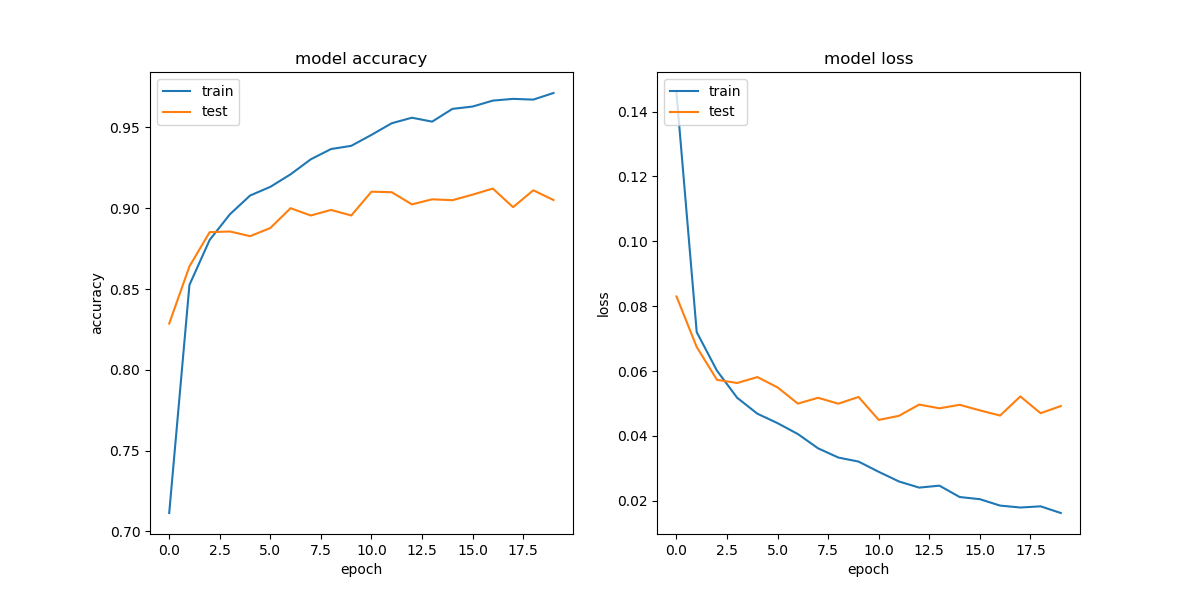

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(121)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(122)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('LearningCurve-{}.png'.format(modelDesc))

Confusion matrix and persicion recall

<IPython.core.display.Javascript object>


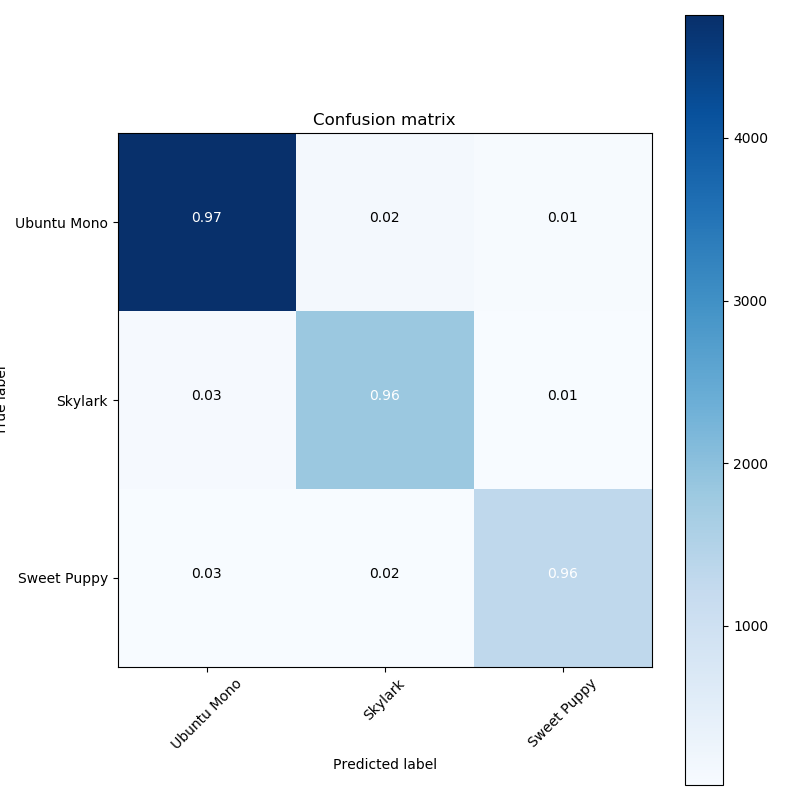

In [82]:
pred_classes = np.argmax(predictions, axis=1)
labels = np.argmax(test_y, axis=1)
confusion_matrix = tf.math.confusion_matrix(
    labels, pred_classes, num_classes=3, weights=None, dtype=tf.dtypes.int32,
    name=None
)

fig = plot_confusion_matrix(np.array(confusion_matrix), fontClasses)
fig.savefig('ConfusionMatrix-{}.png'.format(modelDesc))

Metrics report

In [80]:

recall = tf.keras.metrics.Recall()
recall.update_state(test_y, predictions)
persision = tf.keras.metrics.Precision()
persision.update_state(test_y, predictions)
auc = tf.keras.metrics.AUC()
auc.update_state(test_y, predictions)
acc = tf.keras.metrics.CategoricalAccuracy()
acc.update_state(test_y, predictions)
print('Accuracy: ', acc.result().numpy())
print('Recall: ', recall.result().numpy())
print('Persision: ', persision.result().numpy())
print('AUC: ', auc.result().numpy())

Accuracy:  0.96377164
Recall:  0.95401317
Persision:  0.96627134
AUC:  0.9784279


ROC curve

<IPython.core.display.Javascript object>


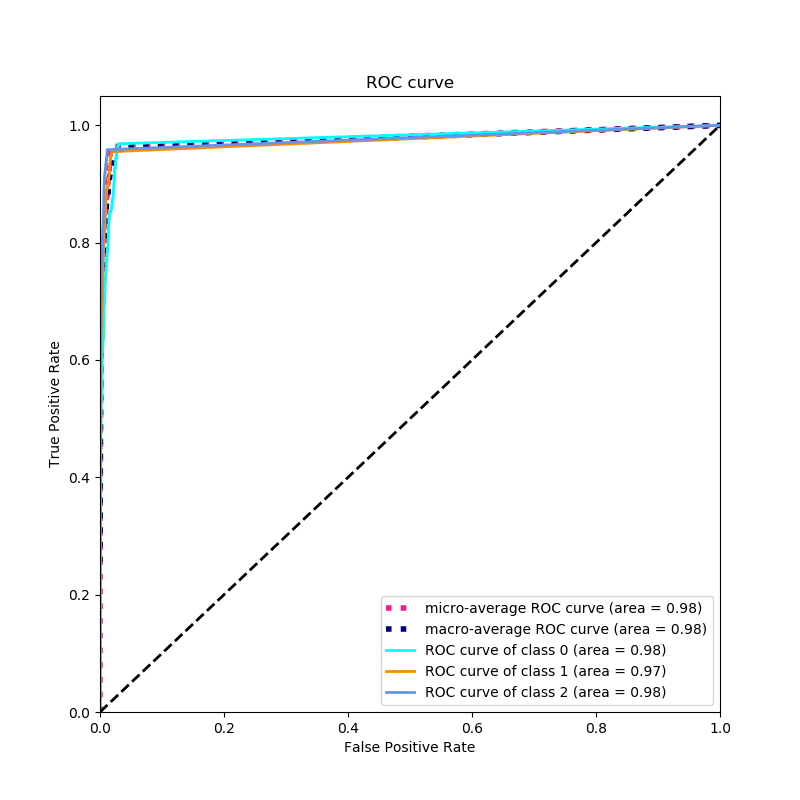

In [81]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

fig2 = plt.figure(figsize=(8,8))
# Plot linewidth.
lw = 2
n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
fig2.show()
fig2.savefig('ROC-{}.png'.format(modelDesc))

# BoW

In [150]:
train = [ [[],[]] for _ in range(len(letters)) ]

# Create dense sift
sift = cv2.SIFT_create()
step_size = 4
# grid Creation assuming all characters are in the same size 32X32
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, 32, step_size) 
                            for x in range(0, 32, step_size)]

descriptors = []
fonts = []

fontClasses = ['Ubuntu Mono', 'Skylark', 'Sweet Puppy']
for i in range(len(images)):
    for w in range(len(images[i]['txt'])):
        for c in range(len(images[i]['words'][w]['characters'])):
            (pts, descs) = sift.compute(images[i]['words'][w]['characters'][c]['resized_aligned'], kp)
            indexL = letters.index(images[i]['words'][w]['characters'][c]['char_txt'])
            fontC = fontClasses.index(images[i]['words'][w]['characters'][c]['font'])
            train[indexL][0].append(descs)
            train[indexL][1].append(fontC)
            
            descriptors.append(descs)
            fonts.append(fontC)

descriptors = np.array(descriptors)
fonts = np.array(fonts)
#chars = np.array(chars)

descriptorsFlat = descriptors.reshape(descriptors.shape[0]*descriptors.shape[1], descriptors.shape[2])

In [151]:
from sklearn.cluster import KMeans, MiniBatchKMeans
n_clust = 100

kmeans = MiniBatchKMeans(n_clusters=n_clust, batch_size=1000, verbose=True)
%time kmeans.fit(descriptorsFlat)

Init 1/3 with method: k-means++
Inertia for init 1/3: 324395968.000000
Init 2/3 with method: k-means++
Inertia for init 2/3: 320677792.000000
Init 3/3 with method: k-means++
Inertia for init 3/3: 323033536.000000
Minibatch iteration 1/78400: mean batch inertia: 113563.792000, ewa inertia: 113563.792000 
Minibatch iteration 2/78400: mean batch inertia: 111653.008000, ewa inertia: 113558.912778 
Minibatch iteration 3/78400: mean batch inertia: 109704.240000, ewa inertia: 113549.069799 
Minibatch iteration 4/78400: mean batch inertia: 110182.320000, ewa inertia: 113540.472741 
Minibatch iteration 5/78400: mean batch inertia: 109037.344000, ewa inertia: 113528.973918 
Minibatch iteration 6/78400: mean batch inertia: 108189.912000, ewa inertia: 113515.340525 
Minibatch iteration 7/78400: mean batch inertia: 109392.768000, ewa inertia: 113504.813459 
Minibatch iteration 8/78400: mean batch inertia: 109056.952000, ewa inertia: 113493.455762 
Minibatch iteration 9/78400: mean batch inertia: 11

Minibatch iteration 87/78400: mean batch inertia: 105651.904000, ewa inertia: 112326.686933 
Minibatch iteration 88/78400: mean batch inertia: 105251.000000, ewa inertia: 112308.619035 
Minibatch iteration 89/78400: mean batch inertia: 105489.224000, ewa inertia: 112291.205583 
Minibatch iteration 90/78400: mean batch inertia: 105335.216000, ewa inertia: 112273.443335 
Minibatch iteration 91/78400: mean batch inertia: 107140.256000, ewa inertia: 112260.335646 
Minibatch iteration 92/78400: mean batch inertia: 107133.832000, ewa inertia: 112247.245023 
Minibatch iteration 93/78400: mean batch inertia: 107726.016000, ewa inertia: 112235.699981 
Minibatch iteration 94/78400: mean batch inertia: 106420.080000, ewa inertia: 112220.849688 
Minibatch iteration 95/78400: mean batch inertia: 107548.064000, ewa inertia: 112208.917643 
Minibatch iteration 96/78400: mean batch inertia: 107007.672000, ewa inertia: 112195.636165 
Minibatch iteration 97/78400: mean batch inertia: 106771.712000, ewa i

Minibatch iteration 176/78400: mean batch inertia: 107360.536000, ewa inertia: 111098.174045 
Minibatch iteration 177/78400: mean batch inertia: 105628.504000, ewa inertia: 111084.207142 
Minibatch iteration 178/78400: mean batch inertia: 107832.720000, ewa inertia: 111075.904409 
Minibatch iteration 179/78400: mean batch inertia: 106145.264000, ewa inertia: 111063.313927 
Minibatch iteration 180/78400: mean batch inertia: 105472.720000, ewa inertia: 111049.038242 
Minibatch iteration 181/78400: mean batch inertia: 107487.680000, ewa inertia: 111039.944247 
Minibatch iteration 182/78400: mean batch inertia: 106139.216000, ewa inertia: 111027.430147 
Minibatch iteration 183/78400: mean batch inertia: 106770.568000, ewa inertia: 111016.560170 
Minibatch iteration 184/78400: mean batch inertia: 106164.312000, ewa inertia: 111004.169865 
Minibatch iteration 185/78400: mean batch inertia: 107545.984000, ewa inertia: 110995.339323 
Minibatch iteration 186/78400: mean batch inertia: 105653.12

Minibatch iteration 269/78400: mean batch inertia: 106668.464000, ewa inertia: 110065.999121 
Minibatch iteration 270/78400: mean batch inertia: 105855.960000, ewa inertia: 110055.248708 
Minibatch iteration 271/78400: mean batch inertia: 104755.840000, ewa inertia: 110041.716570 
Minibatch iteration 272/78400: mean batch inertia: 106076.840000, ewa inertia: 110031.592184 
Minibatch iteration 273/78400: mean batch inertia: 106665.264000, ewa inertia: 110022.996202 
Minibatch iteration 274/78400: mean batch inertia: 104404.752000, ewa inertia: 110008.649911 
Minibatch iteration 275/78400: mean batch inertia: 105387.424000, ewa inertia: 109996.849525 
Minibatch iteration 276/78400: mean batch inertia: 105738.352000, ewa inertia: 109985.975373 
Minibatch iteration 277/78400: mean batch inertia: 105896.688000, ewa inertia: 109975.533302 
Minibatch iteration 278/78400: mean batch inertia: 106117.360000, ewa inertia: 109965.681384 
Minibatch iteration 279/78400: mean batch inertia: 106022.88

Minibatch iteration 364/78400: mean batch inertia: 105388.536000, ewa inertia: 109144.034875 
Minibatch iteration 365/78400: mean batch inertia: 105046.464000, ewa inertia: 109133.571652 
Minibatch iteration 366/78400: mean batch inertia: 105536.112000, ewa inertia: 109124.385472 
Minibatch iteration 367/78400: mean batch inertia: 107208.880000, ewa inertia: 109119.494193 
Minibatch iteration 368/78400: mean batch inertia: 105230.216000, ewa inertia: 109109.562849 
Minibatch iteration 369/78400: mean batch inertia: 104975.296000, ewa inertia: 109099.005922 
Minibatch iteration 370/78400: mean batch inertia: 104803.008000, ewa inertia: 109088.036011 
Minibatch iteration 371/78400: mean batch inertia: 107356.960000, ewa inertia: 109083.615676 
Minibatch iteration 372/78400: mean batch inertia: 106028.848000, ewa inertia: 109075.815271 
Minibatch iteration 373/78400: mean batch inertia: 105861.800000, ewa inertia: 109067.608223 
Minibatch iteration 374/78400: mean batch inertia: 107759.61

Minibatch iteration 460/78400: mean batch inertia: 106305.240000, ewa inertia: 108397.555600 
Minibatch iteration 461/78400: mean batch inertia: 105158.496000, ewa inertia: 108389.284602 
Minibatch iteration 462/78400: mean batch inertia: 104271.584000, ewa inertia: 108378.769977 
Minibatch iteration 463/78400: mean batch inertia: 105692.256000, ewa inertia: 108371.909913 
Minibatch iteration 464/78400: mean batch inertia: 105840.288000, ewa inertia: 108365.445370 
Minibatch iteration 465/78400: mean batch inertia: 104732.384000, ewa inertia: 108356.168280 
Minibatch iteration 466/78400: mean batch inertia: 103819.264000, ewa inertia: 108344.583211 
Minibatch iteration 467/78400: mean batch inertia: 106721.952000, ewa inertia: 108340.439792 
Minibatch iteration 468/78400: mean batch inertia: 105444.224000, ewa inertia: 108333.044251 
Minibatch iteration 469/78400: mean batch inertia: 105507.008000, ewa inertia: 108325.827915 
Minibatch iteration 470/78400: mean batch inertia: 105392.30

Minibatch iteration 560/78400: mean batch inertia: 105580.992000, ewa inertia: 107803.452665 
Minibatch iteration 561/78400: mean batch inertia: 106154.592000, ewa inertia: 107799.242269 
Minibatch iteration 562/78400: mean batch inertia: 104758.048000, ewa inertia: 107791.476523 
Minibatch iteration 563/78400: mean batch inertia: 105631.216000, ewa inertia: 107785.960258 
Minibatch iteration 564/78400: mean batch inertia: 107652.600000, ewa inertia: 107785.619720 
Minibatch iteration 565/78400: mean batch inertia: 105883.168000, ewa inertia: 107780.761774 
Minibatch iteration 566/78400: mean batch inertia: 105626.640000, ewa inertia: 107775.261184 
Minibatch iteration 567/78400: mean batch inertia: 104795.792000, ewa inertia: 107767.653054 
Minibatch iteration 568/78400: mean batch inertia: 105199.016000, ewa inertia: 107761.093992 
Minibatch iteration 569/78400: mean batch inertia: 105427.240000, ewa inertia: 107755.134453 
Minibatch iteration 570/78400: mean batch inertia: 105678.20

Minibatch iteration 664/78400: mean batch inertia: 105844.832000, ewa inertia: 107309.387542 
Minibatch iteration 665/78400: mean batch inertia: 105581.512000, ewa inertia: 107304.975380 
Minibatch iteration 666/78400: mean batch inertia: 105028.064000, ewa inertia: 107299.161244 
Minibatch iteration 667/78400: mean batch inertia: 105191.536000, ewa inertia: 107293.779384 
Minibatch iteration 668/78400: mean batch inertia: 105827.552000, ewa inertia: 107290.035345 
Minibatch iteration 669/78400: mean batch inertia: 104462.848000, ewa inertia: 107282.816070 
Minibatch iteration 670/78400: mean batch inertia: 106184.336000, ewa inertia: 107280.011080 
Minibatch iteration 671/78400: mean batch inertia: 106260.216000, ewa inertia: 107277.407015 
Minibatch iteration 672/78400: mean batch inertia: 105589.000000, ewa inertia: 107273.095636 
Minibatch iteration 673/78400: mean batch inertia: 105847.704000, ewa inertia: 107269.455872 
Minibatch iteration 674/78400: mean batch inertia: 104510.98

Minibatch iteration 753/78400: mean batch inertia: 104580.784000, ewa inertia: 106955.371217 
Minibatch iteration 754/78400: mean batch inertia: 105972.800000, ewa inertia: 106952.862203 
Minibatch iteration 755/78400: mean batch inertia: 105997.664000, ewa inertia: 106950.423087 
Minibatch iteration 756/78400: mean batch inertia: 105881.904000, ewa inertia: 106947.694604 
Minibatch iteration 757/78400: mean batch inertia: 106091.552000, ewa inertia: 106945.508428 
Minibatch iteration 758/78400: mean batch inertia: 103875.960000, ewa inertia: 106937.670279 
Minibatch iteration 759/78400: mean batch inertia: 106327.104000, ewa inertia: 106936.111186 
Minibatch iteration 760/78400: mean batch inertia: 105035.144000, ewa inertia: 106931.257031 
Minibatch iteration 761/78400: mean batch inertia: 106088.880000, ewa inertia: 106929.106006 
Minibatch iteration 762/78400: mean batch inertia: 106068.128000, ewa inertia: 106926.907483 
Minibatch iteration 763/78400: mean batch inertia: 105844.88

Minibatch iteration 860/78400: mean batch inertia: 105771.880000, ewa inertia: 106637.082608 
Minibatch iteration 861/78400: mean batch inertia: 105125.184000, ewa inertia: 106633.221947 
Minibatch iteration 862/78400: mean batch inertia: 106641.824000, ewa inertia: 106633.243912 
Minibatch iteration 863/78400: mean batch inertia: 103893.600000, ewa inertia: 106626.248181 
Minibatch iteration 864/78400: mean batch inertia: 105927.280000, ewa inertia: 106624.463352 
Minibatch iteration 865/78400: mean batch inertia: 105873.464000, ewa inertia: 106622.545662 
Minibatch iteration 866/78400: mean batch inertia: 105517.440000, ewa inertia: 106619.723754 
Minibatch iteration 867/78400: mean batch inertia: 104443.248000, ewa inertia: 106614.166083 
Minibatch iteration 868/78400: mean batch inertia: 106782.496000, ewa inertia: 106614.595916 
Minibatch iteration 869/78400: mean batch inertia: 104680.120000, ewa inertia: 106609.656196 
Minibatch iteration 870/78400: mean batch inertia: 105401.50

Minibatch iteration 957/78400: mean batch inertia: 106987.920000, ewa inertia: 106459.656415 
Minibatch iteration 958/78400: mean batch inertia: 105229.232000, ewa inertia: 106456.514504 
Minibatch iteration 959/78400: mean batch inertia: 106530.160000, ewa inertia: 106456.702559 
Minibatch iteration 960/78400: mean batch inertia: 104726.608000, ewa inertia: 106452.284730 
Minibatch iteration 961/78400: mean batch inertia: 105525.400000, ewa inertia: 106449.917913 
Minibatch iteration 962/78400: mean batch inertia: 105364.360000, ewa inertia: 106447.145921 
Minibatch iteration 963/78400: mean batch inertia: 106577.856000, ewa inertia: 106447.479691 
Minibatch iteration 964/78400: mean batch inertia: 105975.808000, ewa inertia: 106446.275269 
Minibatch iteration 965/78400: mean batch inertia: 105616.144000, ewa inertia: 106444.155513 
Minibatch iteration 966/78400: mean batch inertia: 105543.464000, ewa inertia: 106441.855581 
Minibatch iteration 967/78400: mean batch inertia: 106160.73

Minibatch iteration 1046/78400: mean batch inertia: 105882.224000, ewa inertia: 106289.913495 
Minibatch iteration 1047/78400: mean batch inertia: 105440.368000, ewa inertia: 106287.744164 
Minibatch iteration 1048/78400: mean batch inertia: 106428.360000, ewa inertia: 106288.103230 
Minibatch iteration 1049/78400: mean batch inertia: 105638.968000, ewa inertia: 106286.445651 
Minibatch iteration 1050/78400: mean batch inertia: 106052.616000, ewa inertia: 106285.848562 
Minibatch iteration 1051/78400: mean batch inertia: 105696.000000, ewa inertia: 106284.342373 
Minibatch iteration 1052/78400: mean batch inertia: 105056.648000, ewa inertia: 106281.207433 
Minibatch iteration 1053/78400: mean batch inertia: 104644.336000, ewa inertia: 106277.027651 
Minibatch iteration 1054/78400: mean batch inertia: 104625.024000, ewa inertia: 106272.809229 
Minibatch iteration 1055/78400: mean batch inertia: 105400.096000, ewa inertia: 106270.580740 
Minibatch iteration 1056/78400: mean batch inertia

Minibatch iteration 1140/78400: mean batch inertia: 105988.176000, ewa inertia: 106139.424119 
Minibatch iteration 1141/78400: mean batch inertia: 104502.608000, ewa inertia: 106135.244479 
Minibatch iteration 1142/78400: mean batch inertia: 105745.672000, ewa inertia: 106134.249698 
Minibatch iteration 1143/78400: mean batch inertia: 106155.008000, ewa inertia: 106134.302705 
Minibatch iteration 1144/78400: mean batch inertia: 105352.144000, ewa inertia: 106132.305448 
Minibatch iteration 1145/78400: mean batch inertia: 105421.136000, ewa inertia: 106130.489464 
Minibatch iteration 1146/78400: mean batch inertia: 106535.376000, ewa inertia: 106131.523349 
Minibatch iteration 1147/78400: mean batch inertia: 104310.192000, ewa inertia: 106126.872546 
Minibatch iteration 1148/78400: mean batch inertia: 106010.768000, ewa inertia: 106126.576071 
Minibatch iteration 1149/78400: mean batch inertia: 105310.904000, ewa inertia: 106124.493237 
Minibatch iteration 1150/78400: mean batch inertia

Minibatch iteration 1239/78400: mean batch inertia: 105860.088000, ewa inertia: 106025.995167 
Minibatch iteration 1240/78400: mean batch inertia: 106536.304000, ewa inertia: 106027.298251 
Minibatch iteration 1241/78400: mean batch inertia: 105644.416000, ewa inertia: 106026.320554 
Minibatch iteration 1242/78400: mean batch inertia: 106821.464000, ewa inertia: 106028.350967 
Minibatch iteration 1243/78400: mean batch inertia: 104351.144000, ewa inertia: 106024.068188 
Minibatch iteration 1244/78400: mean batch inertia: 105066.424000, ewa inertia: 106021.622826 
Minibatch iteration 1245/78400: mean batch inertia: 105321.232000, ewa inertia: 106019.834365 
Minibatch iteration 1246/78400: mean batch inertia: 106417.808000, ewa inertia: 106020.850598 
Minibatch iteration 1247/78400: mean batch inertia: 105672.320000, ewa inertia: 106019.960619 
Minibatch iteration 1248/78400: mean batch inertia: 106152.000000, ewa inertia: 106020.297784 
Minibatch iteration 1249/78400: mean batch inertia

Minibatch iteration 1327/78400: mean batch inertia: 105539.744000, ewa inertia: 105922.823529 
Minibatch iteration 1328/78400: mean batch inertia: 106807.944000, ewa inertia: 105925.083700 
Minibatch iteration 1329/78400: mean batch inertia: 105236.320000, ewa inertia: 105923.324929 
Minibatch iteration 1330/78400: mean batch inertia: 105177.360000, ewa inertia: 105921.420094 
Minibatch iteration 1331/78400: mean batch inertia: 104910.160000, ewa inertia: 105918.837823 
Minibatch iteration 1332/78400: mean batch inertia: 104967.824000, ewa inertia: 105916.409391 
Minibatch iteration 1333/78400: mean batch inertia: 105482.176000, ewa inertia: 105915.300568 
Minibatch iteration 1334/78400: mean batch inertia: 105761.624000, ewa inertia: 105914.908152 
Minibatch iteration 1335/78400: mean batch inertia: 104454.848000, ewa inertia: 105911.179861 
Minibatch iteration 1336/78400: mean batch inertia: 105831.688000, ewa inertia: 105910.976877 
Minibatch iteration 1337/78400: mean batch inertia

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=100, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=True)

In [152]:
histograms = []

# For every decriptive image create a histogram and add to the histograms dataset
for image in descriptors:
    # predict cluster for each image descriptor
    clusters = kmeans.predict(image)
    
    #create histogram for associated clusters to descriptors
    hist, _ = np.histogram(clusters, range(n_clust+1))
    histograms.append(hist)

histograms = np.array(histograms)

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

In [153]:
x_train, x_test, y_train, y_test = train_test_split(histograms, fonts)

In [156]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.fit_transform(x_test)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

C = 0.05
#x_train, x_test, y_train, y_test = train_test_split(X, y1, random_state=0, train_size=split, test_size=(1-split))
svc = OneVsRestClassifier(SVC(kernel='linear', C=C, probability=True, random_state=0, max_iter=1000))
svc.fit(x_train_norm, y_train_cat)
y_score = svc.decision_function(x_test_norm)

C:\Users\nitza\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\nitza\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\nitza\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


--------------------------------------